# **Dataiku Data Scientist Technical Assessment**
### Author : Jules Boistard
### Submission date : January 18th, 2022
___

#### **#2 : Pre-processing and preliminary model selection**

The goal here is to iteratively find the best pre-processing pipeline based on a simple basic machine learning model, adding/removing steps along the way.

This section **does not** aim at finding the best performing model. This will be the focus of the next section ("model selection").

##### **#2.1 : Importing and splitting data**

In [3]:
# Read the train and test files
# NB : we do not want instance weight for machine learning training
import pandas as pd

train = pd.read_csv("data/train_clean.csv", header=0)
test = pd.read_csv("data/test_clean.csv", header=0)
data = pd.concat([train, test], ignore_index=True)

# Split datasets into features set and target variable
# Note : target classes "-50k" and ">50k" will respectively be labelled 0 and 1
X_train = train.iloc[:, :-2]
X_test = test.iloc[:, :-2]
y_train = train.iloc[:, -2].map(lambda s: 0 if "-" in s else 1)
y_test = test.iloc[:, -2].map(lambda s: 0 if "-" in s else 1)

##### **#2.2 : Building baseline models**

As a very first step, we will compare two very basic models, on which we will perform minimal pre-processing :
- One linear : a logistic regression model
- One non linear : a decision tree

Our first pre-processing pipeline will consist in 4 basic steps :
1. Drop columns with ~50% NaN Values (see part 1 : EDA)
2. Impute NaN values with most frequent class for other columns wit missing values (see part 1 : EDA)
3. Encode our remaining categorical features with ordinal encoding for the decision tree (for minimal computation time) and one hot encoding for the logistic regression model
4. Perform standard scaling for our numerical features

In [4]:
# Let us first define different sets of features
base_num_cols = ["age", "wage per hour", "capital gains", "capital losses", "dividends from stocks", "num persons worked for employer", "weeks worked in year"]
base_cat_cols = [col for col in X_train.columns if col not in base_num_cols]

In [54]:
# Preprocessing pipeline builder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder

def build_preprocessor(ordinal_encoding=True, cols_to_drop=[]):    

    cat_cols = list(set(base_cat_cols).difference(set(cols_to_drop)))
    num_cols = list(set(base_num_cols).difference(set(cols_to_drop)))

    categories = [sorted(data[col].dropna().unique()) for col in cat_cols]

    cat_transformer = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OrdinalEncoder(categories=categories) if ordinal_encoding else OneHotEncoder(categories=categories))
    ])

    num_transformer = Pipeline(steps=[
        ("scaler", StandardScaler())
    ])

    preprocessor = ColumnTransformer(transformers=[
        ("dropper", "drop", cols_to_drop),
        ("categorical", cat_transformer, cat_cols),
        ("numerical", num_transformer, num_cols)
    ], remainder="passthrough")

    return preprocessor

In [6]:
# Define evaluation procedure
from sklearn.metrics import classification_report
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

def evaluate_model(model, X_train, y_train, X_test, y_test, curves=True):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print(classification_report(y_test, y_pred, target_names=["Low income (<50k)", "High income (>50k)"], digits=4))

    if curves:
        N, train_score, val_score = learning_curve(model, X_train, y_train, scoring="f1_macro")
        plt.figure()
        plt.plot(N, train_score.mean(axis=1), label="train score")
        plt.plot(N, val_score.mean(axis=1), label="val score")
        plt.legend()


**Important** : we do not value one of the 2 target classes more than the other. In other words, good predictions are equally important for the "low income" and "high income" classes. On the other hand, accuracy will not do because of class imbalance (~94%/6%). We can therefore choose the **macro averaged f1-score** as our performance metric.

                    precision    recall  f1-score   support

 Low income (<50k)     0.9871    0.8435    0.9097     72669
High income (>50k)     0.3201    0.8696    0.4680      6157

          accuracy                         0.8456     78826
         macro avg     0.6536    0.8566    0.6888     78826
      weighted avg     0.9350    0.8456    0.8752     78826



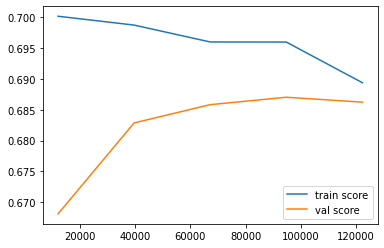

In [7]:
# Building and evaluating a baseline logistic regression model
from sklearn.linear_model import LogisticRegression

lr_clf = Pipeline(steps=[
    ("preprocessing", build_preprocessor(
        ordinal_encoding=False, #One hot encoding
        cols_to_drop = ["migration code-change in msa", "migration code-change in reg", "migration code-move within reg", "migration prev res in sunbelt"]
    )),
    ("classifier", LogisticRegression(max_iter=5000, class_weight="balanced", random_state=42))    
])

evaluate_model(lr_clf, X_train, y_train, X_test, y_test, curves=True)

                    precision    recall  f1-score   support

 Low income (<50k)     0.9552    0.9536    0.9544     72669
High income (>50k)     0.4626    0.4718    0.4672      6157

          accuracy                         0.9159     78826
         macro avg     0.7089    0.7127    0.7108     78826
      weighted avg     0.9167    0.9159    0.9163     78826



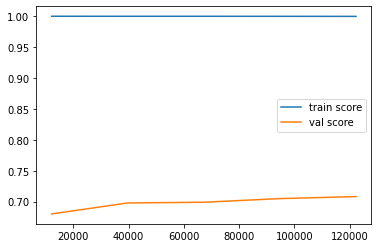

In [8]:
# Building and evaluating a baseline decision tree
from sklearn.tree import DecisionTreeClassifier

dt_clf = Pipeline(steps=[
    ("preprocessor", build_preprocessor(
        ordinal_encoding=True,
        cols_to_drop=["migration code-change in msa", "migration code-change in reg", "migration code-move within reg", "migration prev res in sunbelt"]
    )),
    ("classifier", DecisionTreeClassifier(criterion="entropy", class_weight="balanced", random_state=42))
])

evaluate_model(dt_clf, X_train, y_train, X_test, y_test, curves=True)

A couple things worth noting :
- The **decision tree performs a little bit better** than the logistic regression model. The difference is however not that big. We will therefore continue to compare the both of them throughout the next steps.
- Depending on the context, we could favor one based on individual f1, recall or sensitivity scores for one of the two classes.
- Overall, the performance is not very good. While the f1 score is not too bad on the majority class (low income) it is, as could be expected, quite poor for the minority class (high income).

To adress the issue of underfitting, we will try the following pre-processing operations :
- Perform over-sampling to increase the representation of the minority class
- Perform some feature engineering

##### **#2.3 : Over sampling**

Let us try and perform over sampling through a SMOTE algorithm (Synthetic Minority Oversampling TEchnique). The goal is to artificially create observations for the minority class "in between" real observations from the same class in the feature space, up until the two classes have an equal number of observations

In [9]:
# Try and perform over sampling on the log reg model
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imPipeline

lr_clf_with_smote = imPipeline(steps=[
    ("preprocessor", build_preprocessor(
        ordinal_encoding=False, #One hot encoding
        cols_to_drop=["migration code-change in msa", "migration code-change in reg", "migration code-move within reg", "migration prev res in sunbelt"]
    )),
    ("resampling", SMOTE(sampling_strategy="auto", random_state=42)),
    ("classifier", LogisticRegression(max_iter=5000, class_weight="balanced", random_state=42))
])

evaluate_model(lr_clf_with_smote, X_train, y_train, X_test, y_test, curves=False)

                    precision    recall  f1-score   support

 Low income (<50k)     0.9855    0.8517    0.9137     72669
High income (>50k)     0.3273    0.8520    0.4730      6157

          accuracy                         0.8517     78826
         macro avg     0.6564    0.8518    0.6933     78826
      weighted avg     0.9341    0.8517    0.8793     78826



In [10]:
# Same with decision tree
dt_clf_with_smote = imPipeline(steps=[
    ("preprocessor", build_preprocessor(
        ordinal_encoding=True,
        cols_to_drop=["migration code-change in msa", "migration code-change in reg", "migration code-move within reg", "migration prev res in sunbelt"]
    )),
    ("resampling", SMOTE(sampling_strategy="auto", random_state=42)),
    ("classifier", DecisionTreeClassifier(criterion="entropy", class_weight="balanced", random_state=42))
])
evaluate_model(dt_clf_with_smote, X_train, y_train, X_test, y_test, curves=False)

                    precision    recall  f1-score   support

 Low income (<50k)     0.9576    0.9407    0.9491     72669
High income (>50k)     0.4206    0.5082    0.4603      6157

          accuracy                         0.9069     78826
         macro avg     0.6891    0.7244    0.7047     78826
      weighted avg     0.9156    0.9069    0.9109     78826



We can observe two different results :
- Oversampling did improve the average f1 score of our logistic regression model, although not very much (~ +0.5%)
- The same operation dit **not** improve the performance of our decision tree (~ -1%)

##### **#2.4 : Feature engineering**

We have tried adding observations. Let us now try to add features.

Since we want to preserve some degree of "explainability" in our model, we will not make us of feature engineering algorithm such as polynomial features.

However, we can try and add a couple of features **manually**, following from what we saw during our EDA (see part 1)

In [11]:
def add_binary_features(X):

    X_ = X.copy()

    X_["adult"] = X_["age"].map(lambda val: 1 if val >= 18 else 0)

    X_["working"] = X_["weeks worked in year"].map(lambda val: 1 if val > 0 else 0)

    X_["extra earnings"] = X_.apply(lambda row: 1 if row[["capital gains", "dividends from stocks"]].sum() > 0 else 0, axis=1)

    X_["is hispanic"] = X_["hispanic origin"].map(lambda val: 0 if val == "All other" else 1)

    X_["high academic level"] = X_["education"].map(
        lambda val: 1 if val in ["Bachelors degree(BA AB BS)", "Masters degree(MA MS MEng MEd MSW MBA)", "Prof school degree (MD DDS DVM LLB JD)", "Doctorate degree(PhD EdD)"] else 0
    )
    
    # According to occupation recodes from documentation page 146
    X_["executive or manager"] = X_["detailed occupation recode"].map(lambda val: 1 if val <=3 else 0) 

    # According to industry recodes from documentation page 131
    X_["work in agriculture or industry"] = X_["detailed industry recode"].map(lambda val: 1 if val<=20 else 0)
    X_["work in finance, insurance, real estate or business management"] = X_["detailed industry recode"].map(lambda val: 1 if val in [32, 33, 34, 37] else 0)

    return X_

X_train_extra_features = add_binary_features(X_train)
X_test_extra_features = add_binary_features(X_test)

In [12]:
# Try our new features with the log reg model
lr_clf_with_extra_features = Pipeline(steps=[
    ("preprocessor", build_preprocessor(
        ordinal_encoding=False, #One hot encoding
        cols_to_drop=["migration code-change in msa", "migration code-change in reg", "migration code-move within reg", "migration prev res in sunbelt"]
    )),
    ("classifier", LogisticRegression(max_iter=5000, class_weight="balanced", random_state=42))
])

evaluate_model(lr_clf_with_extra_features, X_train_extra_features, y_train, X_test_extra_features, y_test, curves=False)

                    precision    recall  f1-score   support

 Low income (<50k)     0.9873    0.8469    0.9117     72669
High income (>50k)     0.3252    0.8710    0.4736      6157

          accuracy                         0.8487     78826
         macro avg     0.6562    0.8589    0.6926     78826
      weighted avg     0.9355    0.8487    0.8775     78826



In [13]:
# Same with decision tree
dt_clf_with_extra_features = Pipeline(steps=[
    ("preprocessor", build_preprocessor(
        ordinal_encoding=True,
        cols_to_drop=["migration code-change in msa", "migration code-change in reg", "migration code-move within reg", "migration prev res in sunbelt"]
    )),
    ("classifier", DecisionTreeClassifier(criterion="entropy", class_weight="balanced", random_state=42))
])

evaluate_model(dt_clf_with_extra_features, X_train_extra_features, y_train, X_test_extra_features, y_test, curves=False)

                    precision    recall  f1-score   support

 Low income (<50k)     0.9562    0.9559    0.9560     72669
High income (>50k)     0.4813    0.4835    0.4824      6157

          accuracy                         0.9190     78826
         macro avg     0.7188    0.7197    0.7192     78826
      weighted avg     0.9191    0.9190    0.9190     78826



This time we do have a slight improvement for both models compared to the baseline ones (~ + 0.4% for log reg and +0.6% for decision tree)

We can now try to find which of the features had the most "impact" on prediction in the decision tree

In [18]:
# Feature importance in the decision tree
pd.set_option('display.float_format', lambda x: '%.3f' % x)

dt_feature_imp = pd.DataFrame(data={
    "features": list(set(X_train_extra_features.columns).difference(set(["migration code-change in msa", "migration code-change in reg", "migration code-move within reg", "migration prev res in sunbelt"]))),
    "coef": list(dt_clf_with_extra_features["classifier"].feature_importances_)
})

dt_feature_imp.sort_values("coef", ascending=False)

,features,coef
40,executive or manager,0.172
29,region of previous residence,0.129
33,fill inc questionnaire for veteran's admin,0.127
15,age,0.058
38,detailed household and family stat,0.050
14,state of previous residence,0.049
30,weeks worked in year,0.041
1,family members under 18,0.038
24,detailed occupation recode,0.032
12,capital losses,0.028


Interestingly enough, one of our custom features (executive or manager) is ranking first. On the other hand, the other added features did not provide as much.

Note that if we have to deal with overfitting with a tree-based model, we could try to perform feature selection based on this ranking (eliminating, for instance, the N lowest ranking features)

##### **#2.5 : More complex models**

While we found a couple of preprocessing tricks to improve model performance, there is still room for improvement. Before diving into fine-tuning, we can try out a couple of different models, a little bit more elaborate than our two baselines models.

Following the results above, we will use our newly created features. The will get rid of SMOTE resampling for now.

In [55]:
# Random forest classifier
from sklearn.ensemble import RandomForestClassifier

rf_clf = Pipeline(steps=[
    ("preprocessor", build_preprocessor(
        ordinal_encoding=True,
        cols_to_drop=["migration code-change in msa", "migration code-change in reg", "migration code-move within reg", "migration prev res in sunbelt"]
    )),
    ("classifier", RandomForestClassifier(class_weight="balanced", random_state=42))
])

evaluate_model(rf_clf, X_train_extra_features, y_train, X_test_extra_features, y_test, curves=False)

                    precision    recall  f1-score   support

 Low income (<50k)     0.9514    0.9872    0.9690     72669
High income (>50k)     0.7283    0.4052    0.5207      6157

          accuracy                         0.9417     78826
         macro avg     0.8398    0.6962    0.7448     78826
      weighted avg     0.9340    0.9417    0.9340     78826



In [36]:
# Gradient boosted trees
from sklearn.ensemble import GradientBoostingClassifier

gbt_clf = Pipeline(steps=[
    ("preprocessor", build_preprocessor(
        ordinal_encoding=True,
        cols_to_drop=["migration code-change in msa", "migration code-change in reg", "migration code-move within reg", "migration prev res in sunbelt"]
    )),
    ("classifier", GradientBoostingClassifier(random_state=42))
])

evaluate_model(gbt_clf, X_train_extra_features, y_train, X_test_extra_features, y_test, curves=False)

                    precision    recall  f1-score   support

 Low income (<50k)     0.9528    0.9876    0.9699     72669
High income (>50k)     0.7426    0.4221    0.5383      6157

          accuracy                         0.9434     78826
         macro avg     0.8477    0.7049    0.7541     78826
      weighted avg     0.9363    0.9434    0.9362     78826



                    precision    recall  f1-score   support

 Low income (<50k)     0.9824    0.8895    0.9336     72669
High income (>50k)     0.3836    0.8116    0.5209      6157

          accuracy                         0.8834     78826
         macro avg     0.6830    0.8505    0.7273     78826
      weighted avg     0.9356    0.8834    0.9014     78826



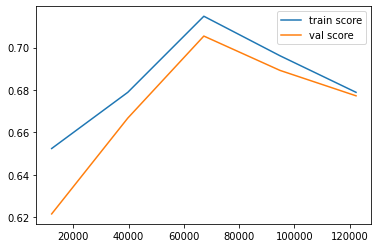

In [51]:
# Stochastic Gradient Descent
from sklearn.linear_model import SGDClassifier

sgd_clf = Pipeline(steps=[
    ("preprocessor", build_preprocessor(
        ordinal_encoding=False, #One hot encoding
        cols_to_drop=["migration code-change in msa", "migration code-change in reg", "migration code-move within reg", "migration prev res in sunbelt"]
    )),
    ("classifier", SGDClassifier(loss="log", class_weight="balanced", random_state=42))
])

evaluate_model(sgd_clf, X_train_extra_features, y_train, X_test_extra_features, y_test, curves=True)

Without any fine-tuning, we can already see that all of these models already outperform our two baselines models.

In the next section, we will compare them with different sets of hyperparameters to find the best predictive model.

In [58]:
# Save preprocessed data for futur use and save computation time

tree_preprocessor = build_preprocessor(
    ordinal_encoding=True,
    cols_to_drop=["migration code-change in msa", "migration code-change in reg", "migration code-move within reg", "migration prev res in sunbelt"]
)
X_train_trees = tree_preprocessor.fit_transform(X_train_extra_features)
X_test_trees = tree_preprocessor.fit_transform(X_test_extra_features)

sgd_preprocessor = build_preprocessor(
    ordinal_encoding=False, #One hot encoding
    cols_to_drop=["migration code-change in msa", "migration code-change in reg", "migration code-move within reg", "migration prev res in sunbelt"]
)
X_train_sgd = sgd_preprocessor.fit_transform(X_train_extra_features)
X_test_sgd = sgd_preprocessor.fit_transform(X_test_extra_features)

##### **#2.6 : A note on feature selection**

Before we dive into fine tuning, it is worth noting that feature selection can sometimes improve model performance, getting rid of noise and avoiding dimensionality issues.

Since we do not have a major problem of overfitting, we will not perform feature selection here.

There is an example of feature selection for the SGD classifier below, yielding a lower f1 score than the "raw" equivalent classifier.

In [52]:
from sklearn.feature_selection import SelectFromModel

sgd_clf_with_fs = Pipeline(steps=[
    ("feature_selec", SelectFromModel(
        estimator=LogisticRegression(max_iter=5000, class_weight="balanced", random_state=42),
        threshold="median"
    )),
    ("classifier", SGDClassifier(loss="log", class_weight="balanced", random_state=42))
])

evaluate_model(sgd_clf_with_fs, X_train_sgd, y_train, X_test_sgd, y_test, curves=False)

                    precision    recall  f1-score   support

 Low income (<50k)     0.9837    0.8697    0.9232     72669
High income (>50k)     0.3504    0.8296    0.4927      6157

          accuracy                         0.8666     78826
         macro avg     0.6670    0.8497    0.7079     78826
      weighted avg     0.9342    0.8666    0.8896     78826



___
#### **#3 : Fine tuning and model assessment**

In this final section, we will perform grid search combined with cross validation to find the best set of hyper parameters for each of our three models, which are :
- Random Forest
- Gradient Boosting
- Stochastic Gradient Descent

We will then pick the overall best performing model for further analysis

In [62]:
from sklearn.model_selection import GridSearchCV

##### **#3.1 : Random Forest**

In [70]:
# Random Forest
rf_params = {
    "n_estimators": [50, 100, 500, 1000],
    "criterion" : ["entropy"],
    "class_weight": ["balanced"]
}

rf_gscsv = GridSearchCV(
    estimator=RandomForestClassifier(),
    param_grid=rf_params,
    scoring="f1_macro",
    verbose=1
)

rf_gscsv = rf_gscsv.fit(X_train_trees, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


In [74]:
from sklearn.metrics import f1_score
print(rf_gscsv.best_score_)
print(rf_gscsv.best_params_)
y_pred = rf_gscsv.best_estimator_.predict(X_test_trees)
score = f1_score(y_test, y_pred, average="macro")
print(score)

0.7491440475165694
{'class_weight': 'balanced', 'criterion': 'entropy', 'n_estimators': 1000}
0.7550356625978092


##### **#3.2 : Gradient Boosting**

In [73]:
gb_params = {
    "n_estimators": [50, 100, 500],
    "learning_rate": [0.1, 0.01, 0.001],
    "max_depth": [3, 5, 10],
}

gb_gscsv = GridSearchCV(
    estimator=GradientBoostingClassifier(),
    param_grid=gb_params,
    scoring="f1_macro",
    verbose=1,
    cv=3
)

gb_gscsv = gb_gscsv.fit(X_train_trees, y_train)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


KeyboardInterrupt: 

##### **#3.3 : SGD**

In [ ]:
sgd_params = {
    "alpha": [0.0001, 0.001, 0.01],
    "penalty": ["l1", "l2"],
    "loss": ["log"],
    "class_weight": ["balanced"]
}

sgd_gscsv = GridSearchCV(
    estimator=GradientBoostingClassifier(),
    param_grid=sgd_params,
    scoring="f1_macro",
    verbose=1,
    cv=3
)

sgd_gscsv = sgd_gscsv.fit(X_train_sgd, y_train)